In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import scipy as sc

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


2.7.0


Found [500] images


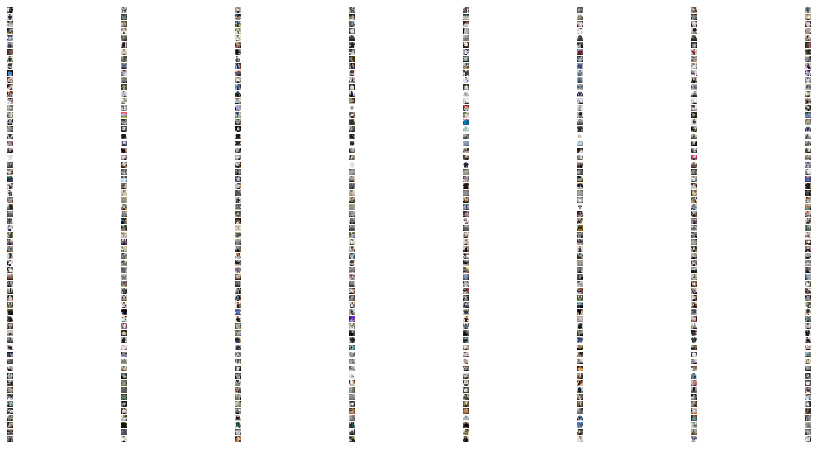

In [2]:
image_paths = glob.glob('/media/sanket/SSD_Windows/Users/Owner/adm/Fashion_Dataset/test/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [3]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

#
# content layers describe the image subject
#
content_layers = ['block5_conv2'] 

#
# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
#
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 

#
# Print shapes of the style layers and embeddings
#
image_tensor = load_image(image_paths[0])
style_tensors = image_to_style(image_tensor)
for k,v in style_tensors.items():
    print(f'Style tensor {k}: {v.shape}')
style_embedding = style_to_vec( style_tensors )
print(f'Style embedding: {style_embedding.shape}')

#
# compute styles
#
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style



  0%|          | 0/500 [00:00<?, ?it/s]

Style tensor block1_conv1: (1, 64, 64)
Style tensor block2_conv1: (1, 128, 128)
Style tensor block3_conv1: (1, 256, 256)
Style embedding: (86016,)


100%|██████████| 500/500 [10:54<00:00,  1.31s/it]


In [4]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

/home/sanket/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sanket/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


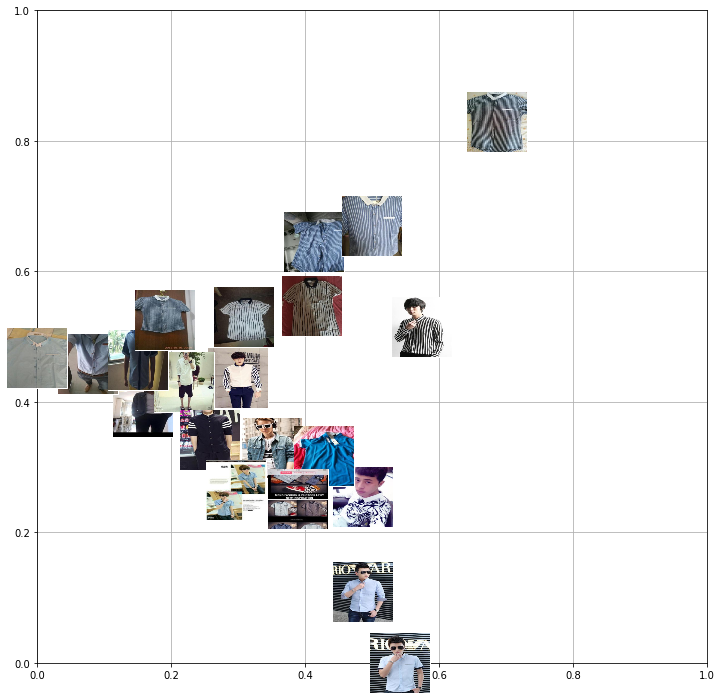

In [5]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, images, thumbnail_sparsity = 0.005, thumbnail_size = 0.3):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))

    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
        shown_images = np.r_[shown_images, [X[i]]]
        thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
        ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10, random_state=0)
X_tsne = tsne.fit_transform( np.array(list(image_style_embeddings.values())) )
embedding_plot(X_tsne, images=list(images.values()))

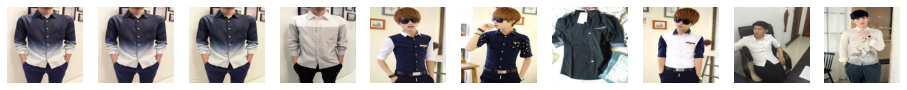

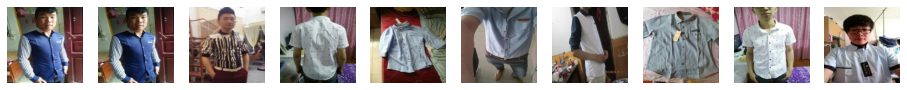

In [7]:
def search_by_style_display(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()

    plt.show()
    

# images mostly match the reference style, although not perfectly
search_by_style_display(image_style_embeddings, images, '3.jpg')
search_by_style_display(image_style_embeddings, images, '71.jpg')

In [9]:
def search_by_style(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
search_by_style(image_style_embeddings, images, '101.jpg')

[('101.jpg', 0),
 ('80.jpg', 0.031435370445251465),
 ('439.jpg', 0.03712761402130127),
 ('242.jpg', 0.04215550422668457),
 ('288.jpg', 0.043598830699920654),
 ('422.jpg', 0.04458177089691162),
 ('445.jpg', 0.04472243785858154),
 ('222.jpg', 0.04501396417617798),
 ('159.jpg', 0.04506492614746094),
 ('1.jpg', 0.045494794845581055),
 ('160.jpg', 0.0457463264465332)]

In [11]:
x = []
for image_name in tqdm(images.keys()):
    z = search_by_style(image_style_embeddings, images, image_name)
    x.append(z)

100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


In [13]:
import pandas as pd
y = pd.DataFrame(x)
y

,0,1,2,3,4,5,6,7,8,9,10
0,"(0.jpg, 0)","(27.jpg, 0.04288262128829956)","(37.jpg, 0.044410765171051025)","(150.jpg, 0.04534703493118286)","(5.jpg, 0.045391201972961426)","(119.jpg, 0.049942612648010254)","(437.jpg, 0.04996210336685181)","(287.jpg, 0.052023887634277344)","(457.jpg, 0.052523910999298096)","(142.jpg, 0.05283999443054199)","(136.jpg, 0.05297994613647461)"
1,"(1.jpg, 0)","(131.jpg, 0.021379470825195312)","(149.jpg, 0.032695472240448)","(439.jpg, 0.035885751247406006)","(222.jpg, 0.036904215812683105)","(193.jpg, 0.038046956062316895)","(95.jpg, 0.04060065746307373)","(54.jpg, 0.042914628982543945)","(391.jpg, 0.0452151894569397)","(101.jpg, 0.045494794845581055)","(394.jpg, 0.046045005321502686)"
2,"(10.jpg, 0)","(179.jpg, 0.038693010807037354)","(41.jpg, 0.07224476337432861)","(23.jpg, 0.08845359086990356)","(469.jpg, 0.09089040756225586)","(499.jpg, 0.09358173608779907)","(178.jpg, 0.09380471706390381)","(100.jpg, 0.09417498111724854)","(288.jpg, 0.09460204839706421)","(495.jpg, 0.09481346607208252)","(276.jpg, 0.09486269950866699)"
3,"(100.jpg, 0)","(288.jpg, 0.03577709197998047)","(422.jpg, 0.03595554828643799)","(274.jpg, 0.037534356117248535)","(235.jpg, 0.038194119930267334)","(336.jpg, 0.03860592842102051)","(51.jpg, 0.04100257158279419)","(85.jpg, 0.042139530181884766)","(7.jpg, 0.04329746961593628)","(482.jpg, 0.04363739490509033)","(333.jpg, 0.04378867149353027)"
4,"(101.jpg, 0)","(80.jpg, 0.031435370445251465)","(439.jpg, 0.03712761402130127)","(242.jpg, 0.04215550422668457)","(288.jpg, 0.043598830699920654)","(422.jpg, 0.04458177089691162)","(445.jpg, 0.04472243785858154)","(222.jpg, 0.04501396417617798)","(159.jpg, 0.04506492614746094)","(1.jpg, 0.045494794845581055)","(160.jpg, 0.0457463264465332)"
...,...,...,...,...,...,...,...,...,...,...,...
495,"(60.jpg, 0)","(325.jpg, 0.03070729970932007)","(251.jpg, 0.03135603666305542)","(24.jpg, 0.03170222043991089)","(186.jpg, 0.034404754638671875)","(193.jpg, 0.035492002964019775)","(342.jpg, 0.03629714250564575)","(428.jpg, 0.03631329536437988)","(86.jpg, 0.03661864995956421)","(475.jpg, 0.03704214096069336)","(34.jpg, 0.03830331563949585)"
496,"(61.jpg, 0)","(266.jpg, 0.09953689575195312)","(434.jpg, 0.10308414697647095)","(346.jpg, 0.10347855091094971)","(215.jpg, 0.10504353046417236)","(13.jpg, 0.10794782638549805)","(62.jpg, 0.10826021432876587)","(267.jpg, 0.11139458417892456)","(310.jpg, 0.11533308029174805)","(26.jpg, 0.11879777908325195)","(309.jpg, 0.12297868728637695)"
497,"(62.jpg, 0)","(26.jpg, 0.07239151000976562)","(267.jpg, 0.0909111499786377)","(13.jpg, 0.09298849105834961)","(463.jpg, 0.10381579399108887)","(434.jpg, 0.10483300685882568)","(209.jpg, 0.10628044605255127)","(61.jpg, 0.10826021432876587)","(462.jpg, 0.11004340648651123)","(261.jpg, 0.11611050367355347)","(346.jpg, 0.11805236339569092)"
498,"(63.jpg, 0)","(155.jpg, 0.03557378053665161)","(413.jpg, 0.0476759672164917)","(137.jpg, 0.04796081781387329)","(51.jpg, 0.04845225811004639)","(338.jpg, 0.05002206563949585)","(336.jpg, 0.05213022232055664)","(327.jpg, 0.05336320400238037)","(348.jpg, 0.05493229627609253)","(324.jpg, 0.05513995885848999)","(238.jpg, 0.05526214838027954)"


In [14]:
def test(neigh):
  return neigh[0]

z = y.applymap(test)

In [15]:
z

,0,1,2,3,4,5,6,7,8,9,10
0,0.jpg,27.jpg,37.jpg,150.jpg,5.jpg,119.jpg,437.jpg,287.jpg,457.jpg,142.jpg,136.jpg
1,1.jpg,131.jpg,149.jpg,439.jpg,222.jpg,193.jpg,95.jpg,54.jpg,391.jpg,101.jpg,394.jpg
2,10.jpg,179.jpg,41.jpg,23.jpg,469.jpg,499.jpg,178.jpg,100.jpg,288.jpg,495.jpg,276.jpg
3,100.jpg,288.jpg,422.jpg,274.jpg,235.jpg,336.jpg,51.jpg,85.jpg,7.jpg,482.jpg,333.jpg
4,101.jpg,80.jpg,439.jpg,242.jpg,288.jpg,422.jpg,445.jpg,222.jpg,159.jpg,1.jpg,160.jpg
...,...,...,...,...,...,...,...,...,...,...,...
495,60.jpg,325.jpg,251.jpg,24.jpg,186.jpg,193.jpg,342.jpg,428.jpg,86.jpg,475.jpg,34.jpg
496,61.jpg,266.jpg,434.jpg,346.jpg,215.jpg,13.jpg,62.jpg,267.jpg,310.jpg,26.jpg,309.jpg
497,62.jpg,26.jpg,267.jpg,13.jpg,463.jpg,434.jpg,209.jpg,61.jpg,462.jpg,261.jpg,346.jpg
498,63.jpg,155.jpg,413.jpg,137.jpg,51.jpg,338.jpg,336.jpg,327.jpg,348.jpg,324.jpg,238.jpg


In [16]:
z.to_csv('Artistic.csv')